# Dependency

In [9]:
import pandas as pd
import numpy as np
from pandas_datareader import data as wb # datareader supports multiple financial database including yahoo and google
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller as ADF
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

%matplotlib inline

# Data Fetching
## Start & End Date

In [43]:
date_rang_month = 3
start_date = datetime.date.today() + relativedelta(months=-date_rang_month)
end_date = datetime.date.today()

## Tesla Stock

In [44]:
def data_loader(tickers):
    stock_dfs = list()
    for ticker, source in tickers:
        if source == "fred":
            df = pd.DataFrame(wb.DataReader(ticker, 
                                            data_source = source, 
                                            start = start_date + relativedelta(days = -1), 
                                            end = end_date))
        else:
            df = pd.DataFrame(wb.DataReader(ticker, 
                                            data_source = source, 
                                            start = start_date, 
                                            end = end_date))
        stock_dfs.append(df)
    return stock_dfs

In [16]:
tickers = \
[
    ("TSLA", "yahoo"), # 0, TESLA Stock
]

tsla_df = data_loader(tickers)[0]
time_series = tsla_df["Close"]



# Data Cleaning
Simply, we assume that there are no typos in our dataframes.

In [17]:
if np.sum(time_series.isnull()) > 0:
    print("The time series contain missing values & we use interpolation to resolve this issue")
    time_series = time_series.interpolate(method='polynomial', order=2, limit_direction='forward', axis=0)
# Then, if there is still some missing values, we simply drop this value.abs
time_series = time_series.dropna()



# Data Splitting

In [18]:
train = time_series[0:round(len(time_series) * 2 /3)]
test = time_series[round(len(time_series) * 2 / 3):len(time_series)]

# Data Processing
## Check If Stationary

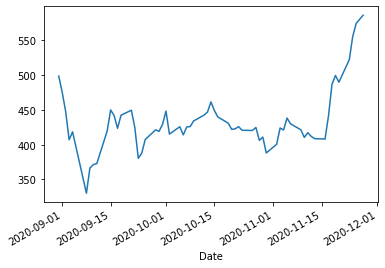

In [19]:
# plot the time series
time_series.plot()

In [20]:
time_series_adf = ADF(time_series.to_list())
print("timeserise_adf: " + str(time_series_adf))

timeserise_adf: (0.7713548399336475, 0.9911594242615474, 6, 56, {'1%': -3.552928203580539, '5%': -2.9147306250000002, '10%': -2.595137155612245}, 435.705567417015)


From above plot, it seems that the time series are not stationary. Also, the statistics given from ADF test shows that there is no evidence to reject the null hypothesis that the time series are not stationary. Therefore, we should perform time series decomposition to firstly extract trend, seasonality and residual series from the original series.

## Time Series Decomposition

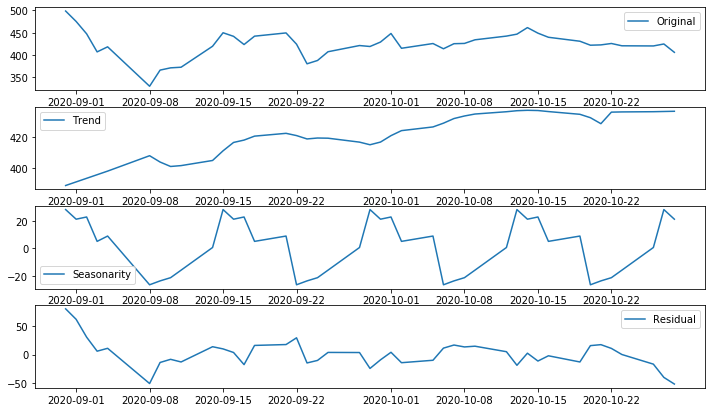

In [23]:
season_period = 10 # hyperparameter
def decomposing(timeseries):
    decomposition = seasonal_decompose(timeseries, model='additive', extrapolate_trend='freq', period=season_period)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.figure(figsize=(12, 7))
    plt.subplot(411)
    plt.plot(timeseries, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonarity')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residual')
    plt.legend(loc='best')
    plt.show()

    return trend, seasonal, residual

train.indexes = train.reset_index()["Date"].apply(pd.to_datetime) # transform times series' index to type Datetime
trend_train, seasonal_train, residual_train = decomposing(train)

## ADF Check Again

In [24]:
def diff(timeseries):
    timeseries_diff1 = timeseries.diff(1)
    timeseries_diff2 = timeseries_diff1.diff(1)

    timeseries_diff1 = timeseries_diff1.fillna(0)
    timeseries_diff2 = timeseries_diff2.fillna(0)

    timeseries_adf = ADF(timeseries.tolist())
    timeseries_diff1_adf = ADF(timeseries_diff1.tolist())
    timeseries_diff2_adf = ADF(timeseries_diff2.tolist())

    print('timeseries_adf : ', timeseries_adf)
    print('timeseries_diff1_adf : ', timeseries_diff1_adf)
    print('timeseries_diff2_adf : ', timeseries_diff2_adf)

    plt.figure(figsize=(10, 5))
    plt.plot(timeseries, label='Original', color='blue')
    plt.plot(timeseries_diff1, label='Diff1', color='red')
    plt.plot(timeseries_diff2, label='Diff2', color='purple')
    plt.legend(loc='best')
    plt.show()

timeseries_adf :  (-1.9623632501387671, 0.3033152974147221, 1, 40, {'1%': -3.6055648906249997, '5%': -2.937069375, '10%': -2.606985625}, 141.53752994442235)
timeseries_diff1_adf :  (-5.147591936709891, 1.1237442815519974e-05, 0, 41, {'1%': -3.60098336718852, '5%': -2.9351348158036012, '10%': -2.6059629803688282}, 141.8343187955349)
timeseries_diff2_adf :  (-6.690412782512414, 4.123263094689953e-09, 1, 40, {'1%': -3.6055648906249997, '5%': -2.937069375, '10%': -2.606985625}, 151.80162484570943)


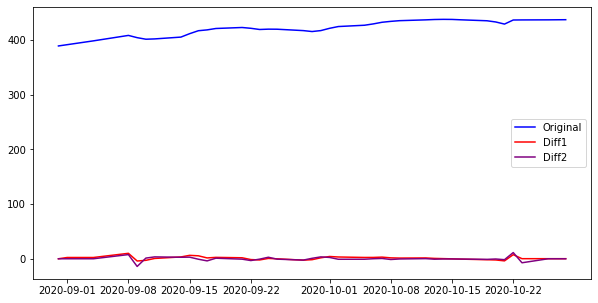

In [25]:
diff(trend_train)

timeseries_adf :  (-6.828143015493684, 1.924170922506968e-09, 4, 72, {'1%': -3.524624466842421, '5%': -2.9026070739026064, '10%': -2.5886785262345677}, 529.2875491807313)
timeseries_diff1_adf :  (-6.601277473581615, 6.7261557204819574e-09, 7, 69, {'1%': -3.528889992207215, '5%': -2.9044395987933362, '10%': -2.589655654274312}, 542.7903661436685)
timeseries_diff2_adf :  (-5.677680768409101, 8.629244637030337e-07, 11, 65, {'1%': -3.5352168748293127, '5%': -2.9071540828402367, '10%': -2.5911025443786984}, 562.079026182826)


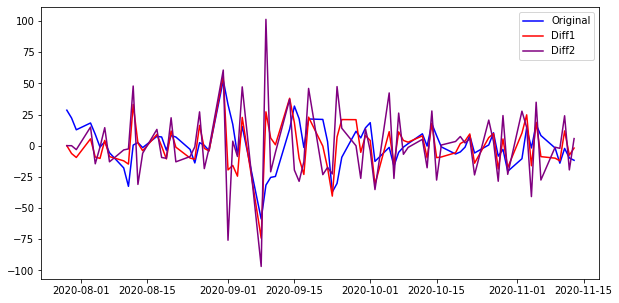

In [187]:
diff(residual_train)

In [26]:
trend_train = trend_train.diff(1)
trend_train = trend_train.fillna(0)


Clearly, from above plots, both series are stationary which fits our assumption for arima model

# ARIMA model
## Find p, d, q

In [27]:
trend_evaluate = sm.tsa.arma_order_select_ic(trend_train, ic=['aic', 'bic'], trend='nc', max_ar=4,
                                            max_ma=4)
print('trend AIC', trend_evaluate.aic_min_order)
print('trend BIC', trend_evaluate.bic_min_order)

D:\JI\software\Anaconda\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\JI\software\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\JI\software\Anaconda\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\JI\software\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\JI\software\Anaconda\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\

In [28]:
residual_evaluate = sm.tsa.arma_order_select_ic(residual_train, ic=['aic', 'bic'], trend='nc', max_ar=4,
                                            max_ma=4)
print('residual AIC', residual_evaluate.aic_min_order)
print('residual BIC', residual_evaluate.bic_min_order)

D:\JI\software\Anaconda\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\JI\software\Anaconda\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\JI\software\Anaconda\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\JI\software\Anaconda\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
residual AIC (0, 4)
residual BIC (1, 0)
D:\JI\software\Anaconda\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInv

## ARIMA Construction

In [29]:
def ARIMA_Model(timeseries, order):
    model = ARIMA(timeseries, order=order)
    return model.fit(disp=0)

In [33]:
trend_model = ARIMA_Model(trend_train, (1, 0, 0))
residual_model = ARIMA_Model(residual_train, (0, 0, 4))


D:\JI\software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\JI\software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


## Model Summary

In [37]:
print(trend_model.summary())

ARMA Model Results                              
Dep. Variable:                  trend   No. Observations:                   42
Model:                     ARMA(1, 0)   Log Likelihood                -102.533
Method:                       css-mle   S.D. of innovations              2.778
Date:                Mon, 30 Nov 2020   AIC                            211.067
Time:                        12:53:37   BIC                            216.280
Sample:                             0   HQIC                           212.978
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.1308      0.525      2.154      0.031       0.102       2.160
ar.L1.trend     0.1877      0.150      1.251      0.211      -0.106       0.482
                                    Roots                                    


In [36]:
print(residual_model.summary())

ARMA Model Results                              
Dep. Variable:                  resid   No. Observations:                   42
Model:                     ARMA(0, 4)   Log Likelihood                -182.245
Method:                       css-mle   S.D. of innovations             17.238
Date:                Mon, 30 Nov 2020   AIC                            376.490
Time:                        12:53:26   BIC                            386.916
Sample:                             0   HQIC                           380.311
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.0193      9.878      0.103      0.918     -18.341      20.380
ma.L1.resid     0.8767      0.306      2.865      0.004       0.277       1.476
ma.L2.resid     0.7453      0.268      2.776      0.005       0.219       1.27

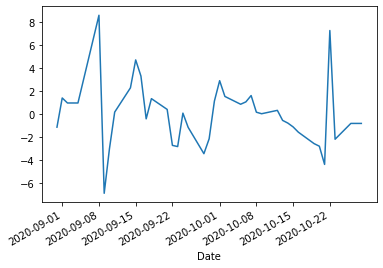

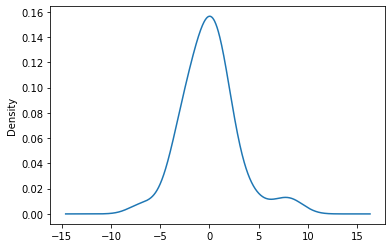

count    42.000000
mean      0.005054
std       2.812360
min      -6.879121
25%      -1.462375
50%       0.062420
75%       1.117840
max       8.596067
dtype: float64


In [38]:
trend_model.resid.plot()
plt.show()
trend_model.resid.plot(kind='kde')
plt.show()
print(trend_model.resid.describe())

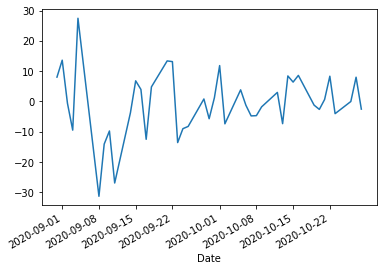

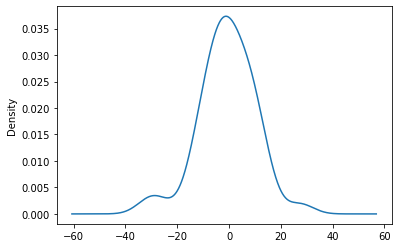

count    42.000000
mean     -0.713679
std      10.724544
min     -31.299758
25%      -6.918752
50%      -0.910443
75%       6.709941
max      27.460034
dtype: float64


In [140]:
residual_model.resid.plot()
plt.show()
residual_model.resid.plot(kind='kde')
plt.show()
print(residual_model.resid.describe())

## Prediction

In [42]:
seasonal_train

Date
2020-08-31    28.424501
2020-09-01    21.382334
2020-09-02    23.001946
2020-09-03     5.158276
2020-09-04     9.046979
2020-09-08   -26.600608
2020-09-09   -23.762240
2020-09-10   -21.409903
2020-09-11   -15.909564
2020-09-14     0.668278
2020-09-15    28.424501
2020-09-16    21.382334
2020-09-17    23.001946
2020-09-18     5.158276
2020-09-21     9.046979
2020-09-22   -26.600608
2020-09-23   -23.762240
2020-09-24   -21.409903
2020-09-25   -15.909564
2020-09-28     0.668278
2020-09-29    28.424501
2020-09-30    21.382334
2020-10-01    23.001946
2020-10-02     5.158276
2020-10-05     9.046979
2020-10-06   -26.600608
2020-10-07   -23.762240
2020-10-08   -21.409903
2020-10-09   -15.909564
2020-10-12     0.668278
2020-10-13    28.424501
2020-10-14    21.382334
2020-10-15    23.001946
2020-10-16     5.158276
2020-10-19     9.046979
2020-10-20   -26.600608
2020-10-21   -23.762240
2020-10-22   -21.409903
2020-10-23   -15.909564
2020-10-26     0.668278
2020-10-27    28.424501
2020-10-28 

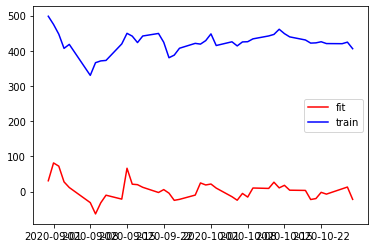

In [40]:
trend_fit_seq = trend_model.fittedvalues
residual_fit_seq = residual_model.fittedvalues

fit_seq = seasonal_train
fit_seq = fit_seq.add(trend_fit_seq, fill_value=0)
fit_seq = fit_seq.add(residual_fit_seq, fill_value=0)

plt.plot(fit_seq, color='red', label='fit')
plt.plot(train, color='blue', label='train')
plt.legend(loc='best')
plt.show()

D:\JI\software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
D:\JI\software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


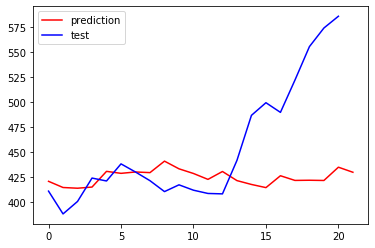

In [136]:
residual_predict_seq = residual_model.predict(start=len(train), end=len(train)+len(test), dynamic=True).reset_index().iloc[:, 1]
trend_predict_seq = trend_model.predict(start=len(train), end=len(train)+len(test), dynamic=True).reset_index().iloc[:, 1]
seasonal_predict_seq = seasonal_train[pd.Timestamp("2020-09-02"):pd.Timestamp("2020-10-01")]

predict_seq = seasonal_predict_seq.reset_index()["seasonal"]
predict_seq = predict_seq.add(trend_predict_seq, fill_value=0)
predict_seq = predict_seq.add(residual_predict_seq, fill_value=0)

plt.plot(predict_seq, color='red', label='prediction')
plt.plot(test.reset_index().iloc[:, 1], color='blue', label='test')
plt.legend(loc='best')
plt.show()
